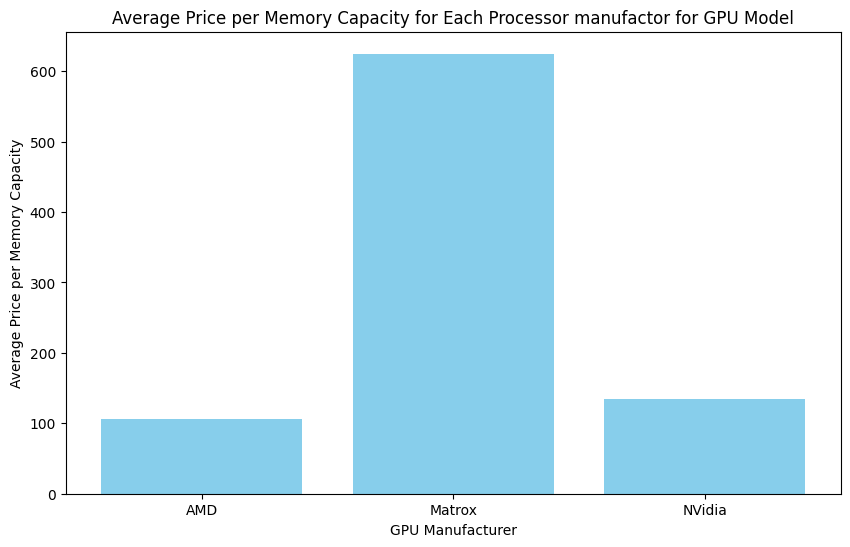

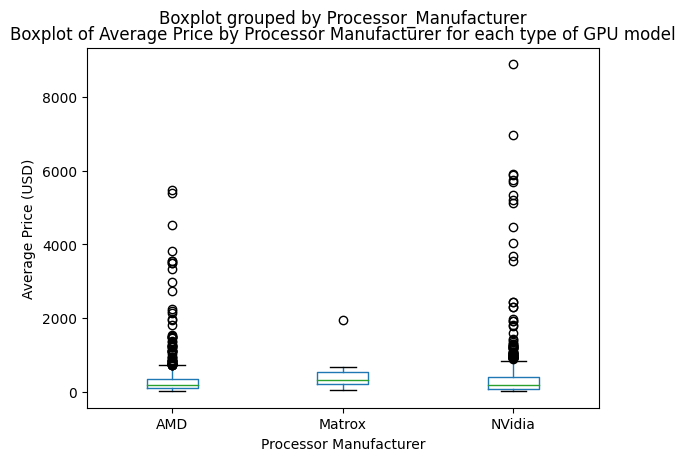

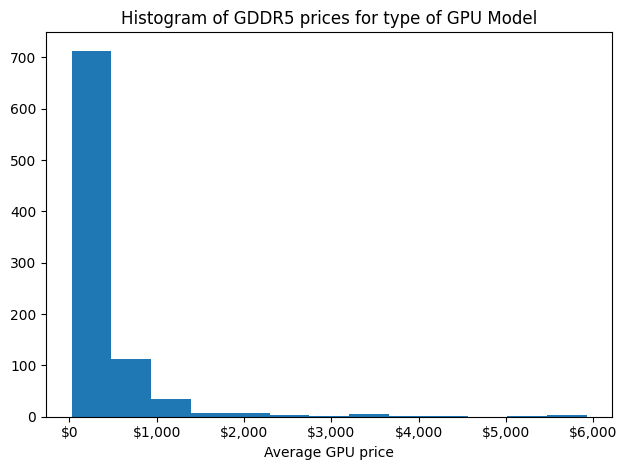

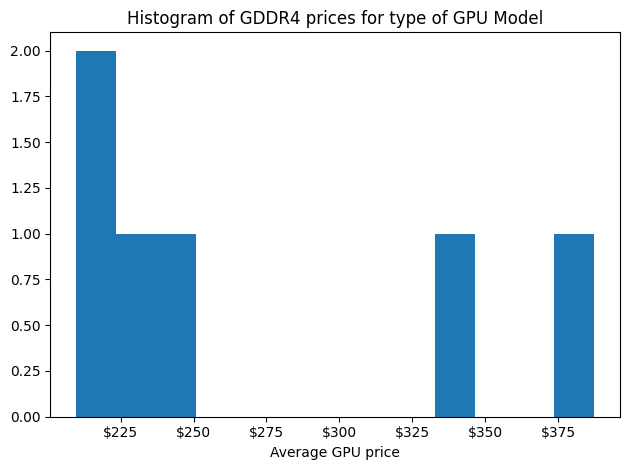

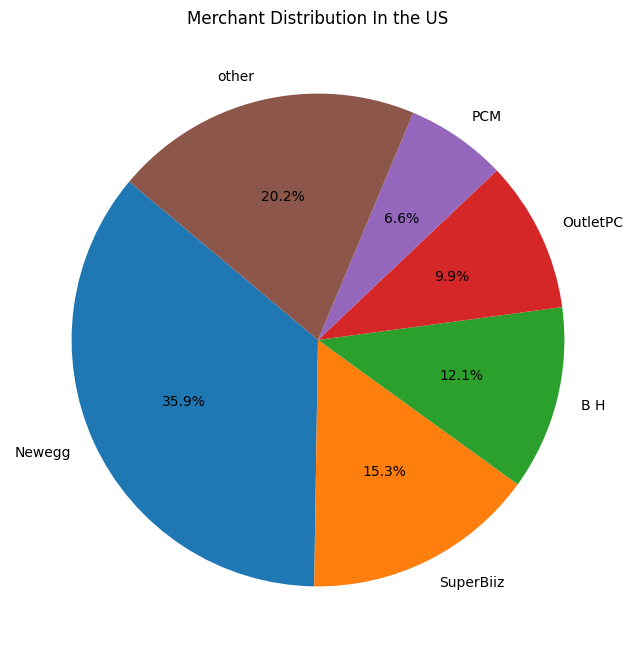

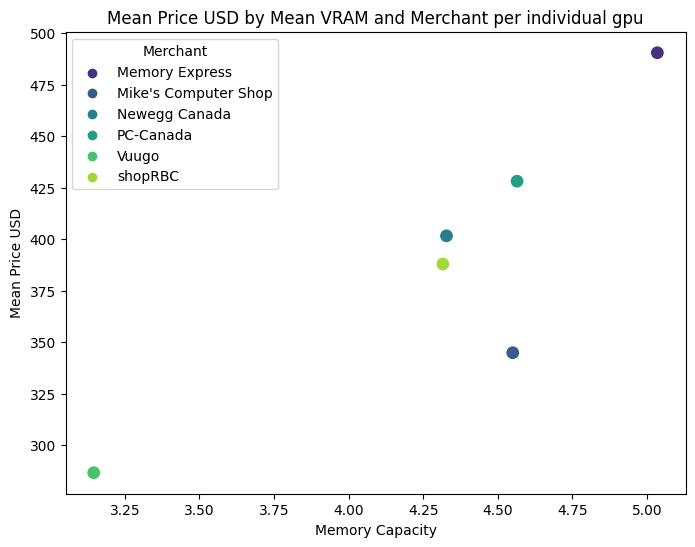

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))


df = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/FACT_GPU_PRICE.csv')
df1 = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/DIM_GPU_PROD.csv')
df2 = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/DIM_REGION.csv')
df3 = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/DIM_MERCHANT.csv')
#cpu_price_df = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/FACT_CPU_PRICE.csv')
#cpu_product_df = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/DIM_CPU_PROD.csv')
#ram_price_df = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/FACT_RAM_PRICE.csv')
#ram_product_df = pd.read_csv('/kaggle/input/ethereum-effect-pc-parts/pc_data/DIM_RAM_PROD.csv')

#groups ProdId values by price_usd and finds the value of each group and makes a dataset
average_prices = df.groupby('ProdId')['Price_USD'].mean().reset_index()
result_df = pd.merge(df, average_prices, on='ProdId', suffixes=('', '_average'))
result_df = result_df.drop_duplicates(subset='ProdId')
result_df = result_df.drop('Price_USD', axis=1).rename(columns={'price_average': 'Price_USD'})
#drops irrelevant columns

#merges and gets rid of the models that dont have a price with inner 
mdf = pd.merge(df1, result_df, left_on='Id', right_on='ProdId', how='inner')
#should print nvidea matrox and Amd.

ndf = pd.merge(mdf, df2, left_on = 'RegionId', right_on = 'Id', how = 'inner')
mpr = ndf.loc[ndf['Price_USD_average'].idxmax()]
ldf = pd.merge(ndf, df3, left_on = 'MerchantId', right_on = 'Id', how = 'inner')
ldf = ldf.drop(columns=['Id_x','TimeId','Id_y'])
#This is for individual products stats not each production

avg_price_per_memory = ldf.groupby('Processor_Manufacturer')['Price_USD_average'].sum() / ldf.groupby('Processor_Manufacturer')['Memory_Capacity'].sum()
avg_price_per_memory = avg_price_per_memory.reset_index(name='Price_USD_average')


# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(avg_price_per_memory['Processor_Manufacturer'], avg_price_per_memory['Price_USD_average'], color='skyblue')
plt.xlabel('GPU Manufacturer')
plt.ylabel('Average Price per Memory Capacity')
plt.title('Average Price per Memory Capacity for Each Processor manufactor for GPU Model')
plt.show()

#box plot
ldf.boxplot(by ='Processor_Manufacturer', column =['Price_USD_average'], grid = False)
plt.title('Boxplot of Average Price by Processor Manufacturer for each type of GPU model')
plt.xlabel('Processor Manufacturer')
plt.ylabel('Average Price (USD)')


#making a histogram of DDR5 memory prices vs DDR4 memory prices per product
DD5 = ldf[ldf['Memory_Type'] == 'GDDR5']
DD4 = ldf[ldf['Memory_Type'] == 'GDDR4']
fig, ax = plt.subplots()
ax.hist(DD5["Price_USD_average"], bins=13)
ax.set_xlabel("Average GPU price")
ax.set_title('Histogram of GDDR5 prices for type of GPU Model')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
fig.tight_layout()
plt.show()
fig, ax = plt.subplots()
ax.hist(DD4["Price_USD_average"], bins=13)
ax.set_xlabel("Average GPU price")
ax.set_title('Histogram of GDDR4 prices for type of GPU Model')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
fig.tight_layout()
plt.show()


# new dataset of all unqiue individual GPU
df3 = df3.rename(columns={'Id': 'MerchantId'})
df2 = df2.rename(columns={'Id': 'RegionId'})
gpu_price_df = pd.merge(df,df2,on="RegionId")
gpu_price_df = gpu_price_df.drop(columns=['RegionId'])
gpu_price_df = pd.merge(gpu_price_df,df3,on="MerchantId")
gpu_price_df = gpu_price_df.drop(columns=['MerchantId'])
merged_gpu = pd.merge(df1,gpu_price_df,left_on="Id",right_on="ProdId")
merged_gpu = merged_gpu.drop(columns=['ProdId','TimeId','Price_Original'])
merged_all_gpu = merged_gpu.groupby('Id').agg({'Price_USD': 'mean'}).reset_index()
merged_gpu = pd.merge(merged_gpu,merged_all_gpu,on="Id")
merged_gpu = merged_gpu.drop(columns=['Price_USD_x'])
merged_gpu = merged_gpu.drop_duplicates()
mgp = merged_gpu.rename(columns={'Price_USD_y': 'Price_USD'})

# make a pie chart of company sales percentage in US
USFILT = mgp[mgp['Code'] == 'us']
USFILT.loc[USFILT['Merchant'] == 'Newegg Marketplace', 'Merchant'] = 'Newegg'
merGB = USFILT.groupby('Merchant')
merGB = USFILT.groupby('Merchant').size().reset_index(name='Count')
lowest_merchants = merGB.nlargest(5, 'Count')
other_merchants = merGB[~merGB['Merchant'].isin(lowest_merchants['Merchant'])]
other_count = other_merchants['Count'].sum()
other_row = pd.DataFrame({'Merchant': ['other'], 'Count': [other_count]})
MerRe = pd.concat([lowest_merchants, other_row])
#display(MerRe)
plt.figure(figsize=(8, 8))
plt.pie(MerRe['Count'], labels=MerRe['Merchant'], autopct='%1.1f%%', startangle=140)
plt.title('Merchant Distribution In the US')
plt.show()

nde = mgp[mgp['Code'] == 'ca']
nde = nde[['Merchant', 'Price_USD', 'Memory_Capacity']]
nde['Merchant'] = nde['Merchant'].replace({'Newegg Canada Marketplace': 'Newegg Canada'})
newlt = nde.groupby('Merchant')
disy = newlt.mean()
#display(disy)
#merDE = nde.groupby('Merchant')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Memory_Capacity', y='Price_USD', hue='Merchant', data=disy, palette='viridis', s=100)
plt.title('Mean Price USD by Mean VRAM and Merchant per individual gpu')
plt.xlabel('Memory Capacity')
plt.ylabel('Mean Price USD')
plt.legend(title='Merchant')
plt.show()





# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session